In [1]:
import os
import time

import numpy as np
import pandas 
import geopandas

from shapely.ops import unary_union
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import re
from pprint import pprint


thisyear = 2018

script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
data_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/districts_with_data/'
output_dir = data_dir

acs5_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/{0:.0f}/estimates/'.format(thisyear)
shapefiledir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/{0:.0f}/'.format(thisyear)
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'
#separated_roads_dir = output_dir = '/home/idies/workspace/Temporary/raddick/jordanraddick.com_temp/roads/{0:}/'.format(this_state.lower())


water_area_tol = 1 * 1000 * 1000
overlap_area_tract_tol = 22000
overlap_area_bg_tol = 4000
#smallest tract in US is Cook County, Illinois Tract 307.02 (area = 22,094 m^2)
#smallest block group in US is Miami-Dade County, FL, Census Tract 2703, block group 7 (area = 4,436 m^2)
equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163

scale = 1
#map_buffer = 0.25 # extra room on each edge of the maps, in degres

#plt.rc('axes', prop_cycle=default_cycler)

district_color_cycle = ['red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite']
inverse_color_cycle = ['green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'maroon', 'seagreen']

debug = 1
g = 0

def makebox(manual_xlim, manual_ylim):

    points = []
    points.append(Point(manual_xlim[0],manual_ylim[1]))
    points.append(Point(manual_xlim[1],manual_ylim[1]))
    points.append(Point(manual_xlim[1],manual_ylim[0]))
    points.append(Point(manual_xlim[0],manual_ylim[0]))
    
    coords = [(p.x, p.y) for p in points]    
    metrobox = Polygon(coords)
    
    return metrobox 

print('ok')

ok


# Get congressional district shapefiles

WITH data on metro and city areas as a percentage of total district area.

This assumes that you have already run <code>districts-cities.ipynb</code>.

In [2]:
s = time.time()
print('reading congressional districts with urban/rural area data...')
cd_gdf = geopandas.read_file(data_dir+'cd116_with_areas_and_types_435.shp')

print('Fixing at-large districts by setting district number to 1...')
cd_gdf.loc[cd_gdf['CD116FP'] == 0, 'CD116FP'] = 1  # At-large districts will be called District 1

cd_gdf = cd_gdf.rename(columns = {'pct_metro_': 'pct_metro_area', 'pct_city_a': 'pct_city_area'})
cd_gdf.loc[:, 'CD116FP'] = cd_gdf['CD116FP'].apply(lambda x: int(x))
cd_gdf = cd_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} districts in {1:,.1f} seconds.'.format(len(cd_gdf), e-s))
#sorted(cd_gdf[cd_gdf['CD116FP'] == 0]['STUSAB'].tolist())


reading congressional districts with urban/rural area data...
Fixing at-large districts by setting district number to 1...
Read 435 districts in 2.4 seconds.


# Load block groups (nationwide)

In [3]:
s = time.time()
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()

for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)

print('converting block group identifiers and coords to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: x[0:4]+'.'+x[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')
bg_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(bg_gdf['INTPTLAT'], errors='coerce')
bg_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(bg_gdf['INTPTLON'], errors='coerce')

#bg_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_gdf['NAME'], errors='coerce')
# bg_gdf = tract_gdf.sort_values(by='NAME')

print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))
bg_gdf = bg_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
if (debug >= 1):
    print('Read {0:,.0f} census block groups in {1:,.1f} seconds!'.format(len(bg_gdf), e-s))

#bg_gdf.sample(1).T


	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
converting block group identifiers and coords to numeric...
assigning GEOID as index...
Read 217,739 census block groups in 147.5 seconds!


## Look up state and county names from numbers

In [4]:
s = time.time()

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
state_codes_df = state_codes_df.rename(columns={'STATE': 'STATEFP'})
bg_gdf = bg_gdf.reset_index().merge(state_codes_df, how='left', on='STATEFP').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATEFP', 'County Code (FIPS)': 'COUNTYFP', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
bg_gdf = bg_gdf.reset_index().merge(county_names_df[['STATEFP', 'COUNTYFP', 'COUNTY_NAME']], how='left', on=['STATEFP', 'COUNTYFP']).set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Added state and county names in {0:,.1f} seconds!'.format(e-s))


looking up state names from numbers...
looking up county names from numbers...
Added state and county names in 14.7 seconds!


## Get population data, and join onto shapefiles

In [5]:
s = time.time()
print('reading ACS5 census data for {0:.0f}...'.format(thisyear))
acs5_estimates_df = pandas.read_csv(acs5_dir+'estimates_acs{0:}_tract_bg_gerrymandering.csv'.format(thisyear), index_col='GEOID')

print('joining population data onto block group shapefiles...')
bg_gdf = bg_gdf.join(acs5_estimates_df[['B01001_001', 'Geography Name']], how='left')
bg_gdf = bg_gdf.rename(columns={'B01001_001': 'total_population'})

e = time.time()
g = g + (e-s)
print('\nadded ACS5 census data to {0:,.0f} block groups in {1:,.0f} seconds!'.format(len(bg_gdf), e-s))


reading ACS5 census data for 2018...
joining population data onto block group shapefiles...

added ACS5 census data to 217,739 block groups in 4 seconds!


# Geo-match congressional districts

If a tract overlaps with only one district, match that tract to its district.
If it overlaps multiple districts, divide into block groups and match each block group to its matching districts.

## Get what has been matched so far

In [6]:
s = time.time()
print('reading districts that have been matched so far...')
assembler_df = pandas.read_csv(data_dir+'block_group_with_district_1_8.csv', encoding='utf-8', index_col='GEOID')
assembler_gdf = geopandas.GeoDataFrame(assembler_df.join(bg_gdf.geometry))
assembler_gdf.crs = bg_gdf.crs


cd_gdf = cd_gdf[~cd_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]
bg_gdf = bg_gdf[~bg_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]

print('backing up...')
cd_gdf_bk = cd_gdf
bg_gdf_bk = bg_gdf
assembler_gdf_bk = assembler_gdf

e = time.time()
g = g + (e-s)
print('Kept {0:,.0f} block groups in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))




reading districts that have been matched so far...
backing up...
Kept 149,477 block groups in 1.3 seconds!


## States with 9 districts

These are harder, because first we have to know which block groups overlap multiple districts.

Create a function to mark those.

### Create function to mark block groups with the districts they overlap

In [7]:
def mark_block_groups_with_districts_bitmask_values(block_group_info_gdf, congressional_district_info_gdf, debug=0):    
    working_with_state = block_group_info_gdf['STATE_NAME'].head(1).values[0]
    
    marked_s = pandas.Series()
    
    equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
    cnt = 0
    if (debug > 0):    
        print('\tAssigning bitmask values to block groups in {0:}...'.format(working_with_state))
    
    for ix, thisrow in block_group_info_gdf.iterrows():    
        bitmasker = 0
        if (debug > 1):
            print(ix)
            print('\t\tMatching {0:}, {1:} census tract {2:}, block group {3:}...'.format(thisrow['STATE_NAME'], thisrow['COUNTY_NAME'], thisrow['TRACTCE'], thisrow['BLKGRPCE']))
            print('\n')
        if ((np.mod(cnt,100) == 0) | (cnt == len(block_group_info_gdf) - 1)):
            if (debug > 1):
                print('\t\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(bg_gdf[bg_gdf['STUSAB'] == this_state])))
            else:
                print('\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(bg_gdf[bg_gdf['STUSAB'] == this_state])))
                
        for jx, thatrow in congressional_district_info_gdf.iterrows():
            if (thisrow.geometry.intersects(thatrow.geometry)):
                this_district_overlap_area = block_group_info_gdf[block_group_info_gdf.index == ix].to_crs(equal_area_crs).geometry.values[0].intersection(congressional_district_info_gdf[congressional_district_info_gdf.index == jx].to_crs(equal_area_crs).geometry.values[0]).area
                if (this_district_overlap_area >= overlap_area_bg_tol):
                    bitmasker = bitmasker + 2**(thatrow['CD116FP']-1)
                    if (debug > 1):
                        print('\t\t\t\tIntersects District {0:.0f} with overlap area {1:,.1f} km^2...'.format(thatrow['CD116FP'], this_district_overlap_area/1000000))               
        marked_s.loc[ix] = bitmasker
        cnt = cnt + 1
        
    return marked_s
print('defined district-marking function!')
assembler_gdf.groupby('STUSAB')['block_based_district'].max().sort_values(ascending=False)


defined district-marking function!


STUSAB
MO    8.0
WI    8.0
MD    8.0
MN    8.0
AL    7.0
SC    7.0
CO    7.0
KY    6.0
LA    6.0
CT    5.0
OK    5.0
OR    5.0
KS    4.0
NV    4.0
IA    4.0
AR    4.0
UT    4.0
MS    4.0
NE    3.0
WV    3.0
NM    3.0
ME    2.0
NH    2.0
ID    2.0
RI    2.0
HI    2.0
DE    1.0
WY    1.0
MT    1.0
ND    1.0
SD    1.0
VT    1.0
AK    1.0
Name: block_based_district, dtype: float64

## Find block group / district overlaps, assign districts to non-overlapping block groups

Uses function defined above

In [8]:
s = time.time()

print('getting from backup...')
bg_gdf = bg_gdf_bk
assembler_gdf = assembler_gdf_bk

e = time.time()
g = g + (e-s)

for this_state in ['AZ', 'IN', 'MA', 'TN']:
    s = time.time()
    state_full_name = bg_gdf[bg_gdf['STUSAB'] == this_state]['STATE_NAME'].values[0]
    print('\n')
    print('Processing {0:}...'.format(state_full_name))
    assembler_i_gdf = bg_gdf[bg_gdf['STUSAB'] == this_state]

    district_bitmask_values_s = mark_block_groups_with_districts_bitmask_values(
        bg_gdf[bg_gdf['STUSAB'] == this_state][['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'total_population', 'geometry']], 
        cd_gdf[cd_gdf['STUSAB'] == this_state][['STUSAB', 'CD116FP', 'geometry']], 
        debug
    )
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask_values = district_bitmask_values_s)
    
    
    if (debug > 0):
        print('\tconverting bitmask values to human-readable bitmasks...')        
    nDistrictsForBitmaskeration = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116FP'].max()
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask = 
                                             assembler_i_gdf['congressional_districts_bitmask_values'].apply(lambda x: 'x'+np.binary_repr(int(x)).zfill(nDistrictsForBitmaskeration)[::-1])
                                            )

    if (debug > 0):
        print('\tcounting number of districts each block group overlaps...')        
    
    assembler_i_gdf = assembler_i_gdf.assign(nDistricts = 
                                             assembler_i_gdf['congressional_districts_bitmask'].apply(lambda x: x[1:].count("1"))
                                            )
    if (debug > 0):
        print('\tassigning congressional district to each block group with only one overlap...')
        
    assembler_i_gdf = assembler_i_gdf.assign(block_based_district = np.nan)
    assembler_i_gdf.loc[
        assembler_i_gdf['nDistricts'] == 1, 
        'block_based_district'] = assembler_i_gdf[
                        assembler_i_gdf['nDistricts'] == 1
                    ]['congressional_districts_bitmask'].apply(lambda x: x.find("1"))
    
    print('\t...-1 otherwise...')
    assembler_i_gdf.loc[assembler_i_gdf['nDistricts'] > 1, 'block_based_district'] = -1
    
    if (debug > 0):
        print('\tjoining {0:} to the rest of the assembler dataframe...'.format(state_full_name))
    assembler_gdf = pandas.concat((assembler_gdf, assembler_i_gdf), axis=0, sort=False)
    if (debug > 0):
        print("\n")
    e = time.time()
    g = g + (e-s)

    print('matched districts for {0:,.0f} block groups in {1:} in {2:,.0f} minutes {3:,.0f} seconds!'.format(len(assembler_i_gdf), this_state, np.floor((e-s)/60), np.floor((e-s)%60)))

print('backing up...')
assembler_gdf_justparsed = assembler_gdf

print('GRAND TOTAL TIME: {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))

# print(assembler_gdf.groupby('STUSAB').size())
# print(assembler_gdf.groupby(['STUSAB', 'nDistricts']).size())
#print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# assembler_gdf.sample(2).T

#assembler_gdf[assembler_gdf['STUSAB'] == this_state].groupby('congressional_districts_bitmask').size()


getting from backup...


Processing Arizona...
	Assigning bitmask values to block groups in Arizona...
		processing row 1 of 4,178...
		processing row 101 of 4,178...
		processing row 201 of 4,178...
		processing row 301 of 4,178...
		processing row 401 of 4,178...
		processing row 501 of 4,178...
		processing row 601 of 4,178...
		processing row 701 of 4,178...
		processing row 801 of 4,178...
		processing row 901 of 4,178...
		processing row 1,001 of 4,178...
		processing row 1,101 of 4,178...
		processing row 1,201 of 4,178...
		processing row 1,301 of 4,178...
		processing row 1,401 of 4,178...
		processing row 1,501 of 4,178...
		processing row 1,601 of 4,178...
		processing row 1,701 of 4,178...
		processing row 1,801 of 4,178...
		processing row 1,901 of 4,178...
		processing row 2,001 of 4,178...
		processing row 2,101 of 4,178...
		processing row 2,201 of 4,178...
		processing row 2,301 of 4,178...
		processing row 2,401 of 4,178...
		processing row 2,501 of 4,178...
		process

In [9]:
s = time.time()
print('Assigning districts based on examination to block groups that overlap multiple districts...')

### ARIZONA
assembler_gdf.loc[['15000US040190044181'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US040130822061'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US040130506053'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US040130927203'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US040139413002'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US040134204013'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US040190047161'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US040190047162', '15000US040190046341', '15000US040190046332'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US040190046321', '15000US040190046243', '15000US040190047132'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US040190047131', '15000US040190046192', '15000US040190046202'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US040190046141', '15000US040190046221', '15000US040190046222', '15000US040190046133', '15000US040190046471', '15000US040190046472', '15000US040190046441', '15000US040190046131'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US040190046132', '15000US040190046452'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US040190046301', '15000US040190046461'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US040219414004', '15000US040210021032', '15000US040190044301'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US040219414005', '15000US040190044231', '15000US040190044252', '15000US040190044193'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US040250018021', '15000US040250016012', '15000US040250016023', '15000US040210022001', '15000US040210008021', '15000US040070008001', '15000US040210004002', '15000US040210023001', '15000US040210010002', '15000US040210008031'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US040159501003', '15000US040159504022', '15000US040250015002', '15000US040250019003', '15000US040250017011', '15000US040250017021', '15000US040250020021', '15000US040070007001', '15000US040210002134', '15000US040210002151', '15000US040210008011', '15000US040210008032'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US040139410001'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US040131167142', '15000US040131167251', '15000US040131167254', '15000US040131167271', '15000US040131167301', '15000US040131167311', '15000US040131167312'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US040190043271', '15000US040190043251', '15000US040190043271'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US040190043161', '15000US040190043162', '15000US040190044182', '15000US040190021001', '15000US040190041181', '15000US040190041141'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US040190006001', '15000US040190006003', '15000US040190006004', '15000US040190016002', '15000US040190016003', '15000US040190016004', '15000US040190020006', '15000US040190007002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US040190015003', '15000US040190014001', '15000US040190014005'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US040279800041', '15000US040270118002'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US040270001001', '15000US040270001002', '15000US040270007002', '15000US040270010032', '15000US040270011002'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US040130506031', '15000US040130506091', '15000US040270010013', '15000US040270010031'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US040131125111'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US040130610191', '15000US040130610192'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US040130610234', '15000US040130610233', '15000US040130610131'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US040134201101'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US040130101021'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US040130101022', '15000US040130101023', '15000US040130304022', '15000US040130304021'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US040130405162', '15000US040130405171'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US040130405162', '15000US040130405171', '15000US040130405181', '15000US040130405191'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US040130405161', '15000US040130405172', '15000US040130610161', '15000US040130610311', '15000US040130610441', '15000US040130610443', '15000US040130610451', '15000US040130610452', '15000US040136100001'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US040130405202'], 'block_based_district'] = 4 
assembler_gdf.loc[['15000US040130405182', '15000US040130405192', '15000US040130405201', '15000US040130405202', '15000US040130405211', '15000US040136108001', '15000US040136109002'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US040134204011', '15000US040134223042', '15000US040134205042'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US040134222161', '15000US040134222164', '15000US040134223042', '15000US040135231044'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US040136143001', '15000US040136120001'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US040136161003', '15000US040136113001', '15000US040136107003', '15000US040136106001', '15000US040136107001', '15000US040136119001', '15000US040136107004', '15000US040136113002'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US040132173003'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US040131046001', '15000US040131055012', '15000US040131051023', '15000US040131052001', '15000US040131060011', '15000US040131051021'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US040130927202'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US040131138021', '15000US040131167331', '15000US040131066001', '15000US040131075003'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US040131167091', '15000US040133201001', '15000US040131171001'], 'block_based_district'] = 9
print('\tfixing for contiguity...')
assembler_gdf.loc[['15000US040130822061'], 'block_based_district'] = 3 # was 1


## INDIANA
assembler_gdf.loc[['15000US180910429003', '15000US180910426001', '15000US180910426004', '15000US180910417002', '15000US180910417003', '15000US180910415001', '15000US180910416002', '15000US180910416003'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US180910416004'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US180859613001', '15000US180859618002', '15000US180859624001', '15000US180859627001'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US180859613002', '15000US180859618001', '15000US180859612004', '15000US180859614002', '15000US180859626002'],  'block_based_district'] = 3
assembler_gdf.loc[['15000US180099751003', '15000US180099754001', '15000US180118101003',  '15000US180670102006'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US180118106012', '15000US180670013001', '15000US180670013002', '15000US180670102003'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US181095110003'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US181095110002'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US180973101031', '15000US180973211002', '15000US180973217004', '15000US180973223001', '15000US180973209031', '15000US180973302043', '15000US180973307001' ], 'block_based_district'] = 5
assembler_gdf.loc[['15000US180973103051', '15000US180973103101', '15000US180973211003', '15000US180973224001', '15000US180973224002', '15000US180973216001', '15000US180973223002', '15000US180973209033', '15000US180973305004', '15000US180973304011', '15000US180973906001', '15000US180973307002'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US181439667002'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US181439669001', '15000US181439671002'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US180259520002', '15000US180259521003'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US180259520001', '15000US180259521002'], 'block_based_district'] = 9


### MASSACHUSETTS
assembler_gdf.loc[['15000US250138101001', '15000US250138102001'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US250138102003'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US250277022001', '15000US250277011005'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US250277011006'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US250214431024'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US250214431022'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US250173651002', '15000US250173651003', '15000US250173651004'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US250092542002', '15000US250092542003', '15000US250092543011', '15000US250092543012'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US250092542001', '15000US250092543022'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US250056121002', '15000US250056122002'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US250056121001', '15000US250056122001', '15000US250056122003'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US250056425002'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US250056410001', '15000US250056420003', '15000US250056417001', '15000US250056417002', '15000US250056413002'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US250056413004', '15000US250056409014', '15000US250056410002', '15000US250056411011', '15000US250056412002'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US250259901010'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US250173546002', '15000US250173546004'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US250173546001', '15000US250173548002', '15000US250173550003', '15000US250259815021'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US250173527002', '15000US250173535001', '15000US250173528001'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US250173528002', '15000US250173530002', '15000US250173533001', '15000US250173530003', '15000US250173534001', '15000US250173535002'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US250259807001', '15000US250214161021'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US250251304041', '15000US250214161014', '15000US250214163002'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US250259815011', '15000US250259818001', '15000US250251101033', '15000US250251205001'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US250250921012', '15000US250250921015', '15000US250250910012', '15000US250250911002', '15000US250250911005', '15000US250250912001', '15000US250251007005'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US250250921014' , '15000US250250911001'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US250250701011'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US250250701018', '15000US250250612001', '15000US250250701012', '15000US250250701013'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US250235202011'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US250239900030'], 'block_based_district'] = 9
    
    
    
# ### TENNESSEE
assembler_gdf.loc[['15000US470890702002', '15000US470890702003'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US470890707001', '15000US470890709001', '15000US470890707002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US470139503001', '15000US470139501001', '15000US470139501002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US470139508001', '15000US470139503002', '15000US470139508002'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US470110109002', '15000US470110111001', '15000US470110111002', '15000US470110111004', '15000US470110115002', '15000US470110115004'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US470110103002'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US471759250002', '15000US471759252001', '15000US471759252002'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US471190102012' , '15000US471190103011', '15000US471190110011', '15000US471190108012'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US471190102011', '15000US471190104004', '15000US471190107001', '15000US471190110012'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US471190106004', '15000US471190107002', '15000US471190107004', '15000US471190108022'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US470210701022', '15000US470210701042', '15000US470210702021'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US470210701041', '15000US470210701043'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US470059630001'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US471570210101', '15000US471570210201'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US471570202101', '15000US471570213424'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US471570202102', '15000US471570202103',  '15000US471570202221', '15000US471570205313', '15000US471570205312', '15000US471570215102', '15000US471570213423', '15000US471570211401'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US471570206321', '15000US471570208321', '15000US471570206511'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US471570211132', '15000US471570211421', '15000US471570206223', '15000US471570206443'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US471570211391', '15000US471570213331'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US471570211111', '15000US471570211123', '15000US471570213421', '15000US471570213203', '15000US471570206212', '15000US471570213332', '15000US471570213311'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US471570086003', '15000US471570092002', '15000US471570092003', '15000US471570086002', '15000US471570085001'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US471570086001', '15000US471570029005', '15000US471570073001', '15000US471570073003'], 'block_based_district'] = 9

# # print("backing up again...")
# # assembler_gdf_bk2 = assembler_gdf

e = time.time()
g = g + (e-s)

#print('Grand total time: {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))

#print(assembler_gdf.groupby('congressional_districts_bitmask').size())
print(assembler_gdf[assembler_gdf['STUSAB'] == this_state].groupby(['STUSAB', 'block_based_district']).size())



Assigning districts based on examination to block groups that overlap multiple districts...
	fixing for contiguity...
STUSAB  block_based_district
TN      1.0                     463
        2.0                     418
        3.0                     500
        4.0                     397
        5.0                     519
        6.0                     418
        7.0                     416
        8.0                     476
        9.0                     518
dtype: int64


# WRITE OUTPUT

In [10]:
s = time.time()
pandas.DataFrame(assembler_gdf[[x for x in assembler_gdf.columns if x != 'geometry']]
                ).to_csv(output_dir+'block_group_with_district_1_9.csv', encoding='utf-8')
e = time.time()
g = g + (e-s)

print('matched districts for {0:,.0f} block groups in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))

print('GRAND TOTAL TIME: {0:,.0f}  minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))


matched districts for 86,364 block groups in 0 minutes 3 seconds!
GRAND TOTAL TIME: 33  minutes 47 seconds!


## Test that output wrote correctly

In [11]:
s = time.time()
z = pandas.read_csv(output_dir+'block_group_with_district_1_9.csv', index_col='GEOID')
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()
for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)
e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))


s = time.time()
print('converting block group identifiers to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: str(x)[0:4]+'.'+str(x)[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')


print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))#
bg_gdf = bg_gdf.set_index('GEOID')

newtestgdf = geopandas.GeoDataFrame(data=z.join(bg_gdf.geometry, how='left'), crs=bg_gdf.crs, geometry='geometry')

e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))



	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
done in 138.7 seconds
converting block group identifiers to numeric...
assigning GEOID as index...
done in 6.1 seconds


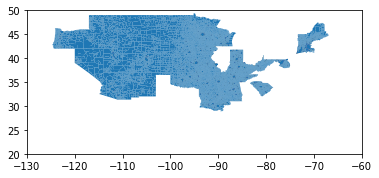

In [34]:
fig,ax = plt.subplots(1,1)
newtestgdf.plot(ax=ax)
plt.xlim(-130,-60)
plt.ylim(20,50)
plt.show()



## TENNESSEE

In [ ]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'TN')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)

# # congressional_districts_bitmask
# # x110000000     5
# # x011000000     6
# # x001100000     7
# # x000101000     3
# # x000100100    12
# # x000011000     5
# # x000000110     1

# # x000000011    37
# # dtype: int64


In [ ]:
# s = time.time()

# this_state = 'TN'
# test_this_bitmask = 'x000000011'

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = True

# manual_xlim = (-71.07,-71.04)
# manual_ylim = (42.285,42.325)






# legend_location = 'lower right'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_bitmask)):
#         if (test_this_bitmask[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))


# #assembler_gdf[assembler_gdf['STUSAB'] == this_state].plot(ax=ax, color='none', edgecolor='yellow', lw=0.5)

# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)


# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
#     & (assembler_gdf.index != '15000US180973209033')
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_gdf.plot(ax=ax, color='none', edgecolor='purple', linewidth=3)
#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#         & (place_gdf['NAME'].isin(['Paradise Valley']))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='purple', backgroundcolor='white', fontsize=10, ha='center'
#                    )
        
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# explore_more = b
# oldi = -1
# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


In [ ]:

# def parse_road_name(thename):
#     try:
#         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#     except AttributeError:
#         try: 
#             annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
#         except AttributeError:
#             annotator = thisrow['FULLNAME']
#     return annotator


# road_label_format = { 
#     'I': { 'labelsize': 20, 'thebbox': dict(boxstyle="darrow", fc='white', ec='blue') }, 
#     'U': { 'labelsize': 18, 'thebbox': dict(boxstyle="square", fc='white', ec='red') },
#     'S': { 'labelsize': 14, 'thebbox': dict(boxstyle="round,pad=0.25,rounding_size=1", fc='white', ec='orange')},
#     'C': { 'labelsize': 12, 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
#     'M': { 'labelsize': 10, 'thecolor': 'black'},
#     'O': { 'labelsize': 10, 'thecolor': 'red' }
# }

# print('ok')


In [ ]:
# s = time.time()

# label_small_roads = True
# label_small_road_types = ['Dr', 'Rd']#['Rd', 'St', 'Way', 'Dr', 'Ln']
# show_places = True
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# #oldi = -1

# i = 4

# map_buffer_ratio = .2


# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# this_block_group_id = '15000US471570211391'


# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if (oldi != i):
#     map_area_geo = makebox(xlimits, ylimits)

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))


# for j in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[j] == '1'):
#         print('Matching District {0:}...'.format(j))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].plot(ax=ax, color=district_color_cycle[j-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=8, zorder=100)
# #map_area_gdf.plot(ax=ax)

# print('finding water overlap...')
# if (oldi != i):
#     water_in_map_area_gdf = water_gdf[water_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
#     #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if (oldi != i):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# #roads_here_gdf[roads_here_gdf['RTTYP'].isnull()].plot(ax=ax, color='black', linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color='black', linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[(roads_in_map_area_gdf['FULLNAME'].notnull()) & (roads_in_map_area_gdf['RTTYP'].isin(['I','U','S','C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center')


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_gdf.plot(ax=ax, color='none', edgecolor='red', lw=5)
#     print('\tlabeling places...')
    

#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=16, ha='center', va='center')


# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     pprint(suffixes_to_count_dict)
#     print(other_roads)
# pprint(this_block_group_id)





In [ ]:
# s = time.time()

# this_state = 'TN'
# this_state_number = 47
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
# place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

# place_gdf = place_gdf.set_index('GEOID')

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')

# # #roads_gdf.head(1).T
# # # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))



## MASSACHUSETTS

In [ ]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'MA')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)

# # congressional_districts_bitmask
# # x110000000     3
# # x011000000     3
# # x010100000     2
# # x001010000     3
# # x001001000     6
# # x000100010     5
# # x000100001    11
# # x000010110     1
# # x000010100    15

# # x000000110    23
# # x000000011     2
# # dtype: int64


In [ ]:
# s = time.time()

# this_state = 'MA'
# test_this_bitmask = 'x000000011'

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = True

# manual_xlim = (-71.07,-71.04)
# manual_ylim = (42.285,42.325)






# legend_location = 'upper left'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_bitmask)):
#         if (test_this_bitmask[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))


# #assembler_gdf[assembler_gdf['STUSAB'] == this_state].plot(ax=ax, color='none', edgecolor='yellow', lw=0.5)

# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)


# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
#     & (assembler_gdf.index != '15000US180973209033')
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_gdf.plot(ax=ax, color='none', edgecolor='purple', linewidth=3)
#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#         & (place_gdf['NAME'].isin(['Paradise Valley']))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='purple', backgroundcolor='white', fontsize=10, ha='center'
#                    )
        
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# explore_more = b
# oldi = -1
# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

    

In [ ]:
# def parse_road_name(thename):
#     try:
#         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#     except AttributeError:
#         try: 
#             annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
#         except AttributeError:
#             annotator = thisrow['FULLNAME']
#     return annotator


# road_label_format = { 
#     'I': { 'labelsize': 20, 'thebbox': dict(boxstyle="darrow", fc='white', ec='blue') }, 
#     'U': { 'labelsize': 18, 'thebbox': dict(boxstyle="square", fc='white', ec='red') },
#     'S': { 'labelsize': 14, 'thebbox': dict(boxstyle="round,pad=0.25,rounding_size=1", fc='white', ec='orange')},
#     'C': { 'labelsize': 12, 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
#     'M': { 'labelsize': 10, 'thecolor': 'black'},
#     'O': { 'labelsize': 10, 'thecolor': 'red' }
# }

# print('ok')


In [ ]:
# s = time.time()

# label_small_roads = True
# label_small_road_types = ['Rd', 'St']#['Rd', 'St', 'Way', 'Dr', 'Ln']
# show_places = True
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# oldi = -1

# i = 0
# map_buffer_ratio = .5


# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# #this_block_group_id = '15000US250259815021'


# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if (oldi != i):
#     map_area_geo = makebox(xlimits, ylimits)

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))


# for j in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[j] == '1'):
#         print('Matching District {0:}...'.format(j))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].plot(ax=ax, color=district_color_cycle[j-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=8, zorder=100)
# #map_area_gdf.plot(ax=ax)

# print('finding water overlap...')
# if (oldi != i):
#     water_in_map_area_gdf = water_gdf[water_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
#     #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if (oldi != i):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# #roads_here_gdf[roads_here_gdf['RTTYP'].isnull()].plot(ax=ax, color='black', linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color='black', linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[(roads_in_map_area_gdf['FULLNAME'].notnull()) & (roads_in_map_area_gdf['RTTYP'].isin(['I','U','S','C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center')


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=5)
#     print('\tlabeling places...')
    

#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=16, ha='center', va='center')


# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     pprint(suffixes_to_count_dict)
#     print(other_roads)
# pprint(this_block_group_id)


In [ ]:
# s = time.time()

# this_state = 'MA'
# this_state_number = 25
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
# place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

# place_gdf = place_gdf.set_index('GEOID')

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')

# # #roads_gdf.head(1).T
# # # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))



## INDIANA

In [ ]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'IN')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)

# # congressional_districts_bitmask
# # 1 and 2 (x110000000)     9
# # 2 and 3 (x011000000)     9
# # 3 and 5 (x001010000)     2
# # 4 and 5 (x000110000)     6
# # 4 and 9 (x000100001)     2
# # 5 and 7 (x000010100)    19
# # 6 and 9 (x000001001)     3

# # 8 and 9 (x000000011)     4


### Match overlapping districts

In [ ]:
# s = time.time()

# this_state = 'IN'
# test_this_bitmask = 'x000000011'

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = True

# manual_xlim = (-86.16,-86.08)
# manual_ylim = (39.835,39.875)



# legend_location = 'lower left'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_bitmask)):
#         if (test_this_bitmask[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))


# #assembler_gdf[assembler_gdf['STUSAB'] == this_state].plot(ax=ax, color='none', edgecolor='yellow', lw=0.5)

# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)


# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
#     & (assembler_gdf.index != '15000US180973209033')
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center'
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_gdf.plot(ax=ax, color='none', edgecolor='purple', linewidth=3)
#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#         & (place_gdf['NAME'].isin(['Paradise Valley']))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='purple', backgroundcolor='white', fontsize=10, ha='center'
#                    )
        
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# explore_more = b
# oldi = -1
# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


### Further exploration

In [ ]:
# def parse_road_name(thename):
#     try:
#         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#     except AttributeError:
#         try: 
#             annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
#         except AttributeError:
#             annotator = thisrow['FULLNAME']
#     return annotator


# road_label_format = { 
#     'I': { 'labelsize': 20, 'thebbox': dict(boxstyle="darrow", fc='white', ec='blue') }, 
#     'U': { 'labelsize': 18, 'thebbox': dict(boxstyle="square", fc='white', ec='red') },
#     'S': { 'labelsize': 14, 'thebbox': dict(boxstyle="round,pad=0.25,rounding_size=1", fc='white', ec='orange')},
#     'C': { 'labelsize': 12, 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
#     'M': { 'labelsize': 10, 'thecolor': 'black'},
#     'O': { 'labelsize': 10, 'thecolor': 'red' }
# }

# print('ok')


In [ ]:
# s = time.time()

# label_small_roads = True
# label_small_road_types = ['Rd','Dr','St']#['Rd', 'St', 'Way', 'Dr', 'Ln']
# show_places = True
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# oldi = -1

# i = 2
# map_buffer_ratio = .1


# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# #this_block_group_id = '15000US180973209033'


# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if (oldi != i):
#     map_area_geo = makebox(xlimits, ylimits)

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))


# for j in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[j] == '1'):
#         print('Matching District {0:}...'.format(j))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].plot(ax=ax, color=district_color_cycle[j-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=8, zorder=100)
# #map_area_gdf.plot(ax=ax)

# print('finding water overlap...')
# if (oldi != i):
#     water_in_map_area_gdf = water_gdf[water_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
#     #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if (oldi != i):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# #roads_here_gdf[roads_here_gdf['RTTYP'].isnull()].plot(ax=ax, color='black', linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color='black', linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[(roads_in_map_area_gdf['FULLNAME'].notnull()) & (roads_in_map_area_gdf['RTTYP'].isin(['I','U','S','C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center')


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=5)
#     print('\tlabeling places...')
    

#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=16, ha='center', va='center')


# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     pprint(suffixes_to_count_dict)
#     print(other_roads)
# pprint(this_block_group_id)






### Get water, places, roads

In [ ]:
# s = time.time()

# this_state = 'IN'
# this_state_number = 18
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
# place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

# place_gdf = place_gdf.set_index('GEOID')

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')

# # #roads_gdf.head(1).T
# # # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))



## ARIZONA

In [ ]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'AZ')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)

# # 1 and 2 and 3 (x111000000)     1
# # 1 and 3 and 7 (x101000100)     1
# # 3 and 4 and 8 (x001100010)     1
# # 3 and 7 and 8 (x001000110)     1
# # 4 and 5 and 6 (x000111000)     1
# # 5 and 6 and 9 (x000011001)     1
# # 1 and 2 (x110000000)    22
# # 1 and 3 (x101000000)     7
# # 1 and 4 (x100100000)    22
# # 1 and 7 (x100000100)     1
# # 1 and 9 (x100000001)     7
# # 2 and 3 (x011000000)    19
# # 3 and 4 (x001100000)    11
# # 3 and 7 (x001000100)     1
# # 3 and 8 (x001000010)     5
# # 4 and 5 (x000110000)     1
# # 4 and 6 (x000101000)     5
# # 4 and 8 (x000100010)    20
# # 5 and 6 (x000011000)     1
# # 5 and 9 (x000010001)     5
# # 6 and 8 (x000001010)    10
# # 6 and 9 (x000001001)     7
# # 7 and 8 (x000000110)     1

# # 7 and 9 (x000000101)     7

### Match overlapping districts

In [ ]:
# s = time.time()

# this_state = 'AZ'
# test_this_bitmask = 'x000000101'

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = False

# manual_xlim = (-112.5,-112.35)
# manual_ylim = (33.45,33.65)


# legend_location = 'upper left'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(24,12))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(24,12))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_bitmask)):
#         if (test_this_bitmask[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))


# #assembler_gdf[assembler_gdf['STUSAB'] == this_state].plot(ax=ax, color='none', edgecolor='yellow', lw=0.5)

# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)


# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=13, ha='center'
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_gdf.plot(ax=ax, color='none', edgecolor='purple', linewidth=3)
#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#         & (place_gdf['NAME'].isin(['Paradise Valley']))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='purple', backgroundcolor='white', fontsize=10, ha='center'
#                    )
        
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)

# explore_more = b
# oldi = -1
# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))



## Further investigation

In [ ]:

# def parse_road_name(thename):
#     try:
#         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#     except AttributeError:
#         try: 
#             annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
#         except AttributeError:
#             annotator = thisrow['FULLNAME']
#     return annotator


# road_label_format = { 
#     'I': { 'labelsize': 20, 'thebbox': dict(boxstyle="darrow", fc='white', ec='blue') }, 
#     'U': { 'labelsize': 18, 'thebbox': dict(boxstyle="square", fc='white', ec='red') },
#     'S': { 'labelsize': 14, 'thebbox': dict(boxstyle="round,pad=0.25,rounding_size=1", fc='white', ec='orange')},
#     'C': { 'labelsize': 12, 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
#     'M': { 'labelsize': 10, 'thecolor': 'black'},
#     'O': { 'labelsize': 10, 'thecolor': 'red' }
# }

# print('ok')


In [ ]:
# s = time.time()


# label_small_roads = False
# label_small_road_types = ['Ave','Rd','St']#['Rd', 'St', 'Way', 'Dr', 'Ln']
# show_places = True
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# oldi = -1

# i = 1
# map_buffer_ratio = 5


# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]


# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if (oldi != i):
#     map_area_geo = makebox(xlimits, ylimits)

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))


# for j in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[j] == '1'):
#         print('Matching District {0:}...'.format(j))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].plot(ax=ax, color=district_color_cycle[j-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=8, zorder=100)
# #map_area_gdf.plot(ax=ax)

# print('finding water overlap...')
# if (oldi != i):
#     water_in_map_area_gdf = water_gdf[water_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
#     #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if (oldi != i):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# #roads_here_gdf[roads_here_gdf['RTTYP'].isnull()].plot(ax=ax, color='black', linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color='black', linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[(roads_in_map_area_gdf['FULLNAME'].notnull()) & (roads_in_map_area_gdf['RTTYP'].isin(['I','U','S','C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center')

# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=5)
#     print('\tlabeling places...')
    

#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=16, ha='center', va='center')


# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     pprint(suffixes_to_count_dict)
#     print(other_roads)
# pprint(this_block_group_id)

# #'15000US040131051021'  9



### Get water, roads, places

In [ ]:
# s = time.time()

# this_state = 'AZ'
# this_state_number = 4
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
# place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

# place_gdf = place_gdf.set_index('GEOID')

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')

# # #roads_gdf.head(1).T
# # # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

